In [130]:
import numpy as np
import matplotlib.pyplot as plt
import corner
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import pandas as pd

# For GECCO formatting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True

# Different length of backoff

1
2
3
4
5
6
7
8
9
Loaded
Got finite
Making corner
Hexbin
0 1
0 2
1 2


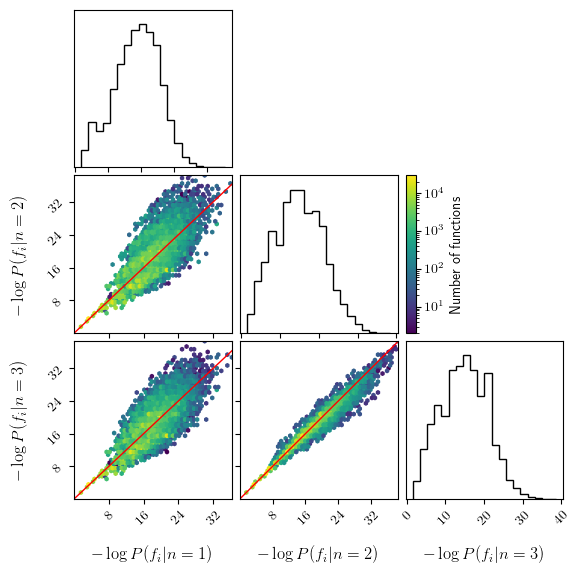

In [297]:
dirname = '../../ESR/esr/function_library/core_maths/'
all_p = [[], [], []]

for c in range(1, 10):
    
    print(c)

    logpar = np.loadtxt(dirname + f'compl_{c}/logconst_{c}.txt')
    
    for i in range(len(all_p)):
        p = np.loadtxt(dirname + f'compl_{c}/katz_codelen_{i+1}_{c}.txt')
        p -= logpar
        all_p[i] += list(p)
print('Loaded')
      
# Get finite values only
all_p = np.array(all_p, dtype=float)
m = np.ones(all_p.shape[1], dtype=bool) 
for i in range(all_p.shape[0]):
    m *= np.isfinite(all_p[i])
all_p = all_p[:,m]
print('Got finite')

labs = [f'$- \log P (f_i | n={i+1})$' for i in range(all_p.shape[0])]
    
fig, axs = plt.subplots(all_p.shape[0], all_p.shape[0], figsize=(6,6))

print('Making corner')
corner.corner(all_p.transpose(),
            labels=labs,
            fig=fig,
            label_kwargs={'fontsize':12},
            plot_contours=False,
            plot_density=False,
            plot_datapoints=False)

bins = np.logspace(0, np.log10(all_p.shape[1]))

print('Hexbin')
for i in range(all_p.shape[0]-1):
    for j in range(i+1, all_p.shape[0]):
        print(i, j)
        hb = axs[j,i].hexbin(all_p[i,:], all_p[j,:], mincnt=1, gridsize=50, bins='log')
        x = axs[j,i].get_xlim()
        axs[j,i].plot(x, x, color='r', lw=1)

ax2_divider = make_axes_locatable(axs[-2,-1])
cax2 = ax2_divider.append_axes("left", size="7%", pad="2%")
cb = fig.colorbar(hb, cax=cax2, orientation="vertical")
cb.set_label(r'Number of functions')

fig.savefig('../figs/backoff_length.pdf', bbox_inches='tight', transparent=True)
        

# Benchmark testing

korns_4_10_0.5_0
korns_4_10_0.5_1
korns_4_10_0.5_2
korns_4_10_0.5_3
korns_4_10_0.5_4
korns_4_30_0.5_0
korns_4_30_0.5_1
korns_4_30_0.5_2
korns_4_30_0.5_3
korns_4_30_0.5_4
korns_4_100_0.5_0
korns_4_100_0.5_1
korns_4_100_0.5_2
korns_4_100_0.5_3
korns_4_100_0.5_4
korns_4_300_0.5_0
korns_4_300_0.5_1
korns_4_300_0.5_2
korns_4_300_0.5_3
korns_4_300_0.5_4
korns_4_1000_0.5_0
korns_4_1000_0.5_1
korns_4_1000_0.5_2
korns_4_1000_0.5_3
korns_4_1000_0.5_4
korns_4_3000_0.5_0
korns_4_3000_0.5_1
korns_4_3000_0.5_2
korns_4_3000_0.5_3
korns_4_3000_0.5_4
korns_4_10000_0.5_0
korns_4_10000_0.5_1
korns_4_10000_0.5_2
korns_4_10000_0.5_3
korns_4_10000_0.5_4
Method Likelihood: 8 of 35 have truth in top 2
Method Score: 0 of 35 have truth in top 2
Method MDL: 34 of 35 have truth in top 2
Method MDL Language Model: 35 of 35 have truth in top 2
Method MDL FBF + Language Model: 35 of 35 have truth in top 2
Method Bayes FBF + Language Model: 35 of 35 have truth in top 2


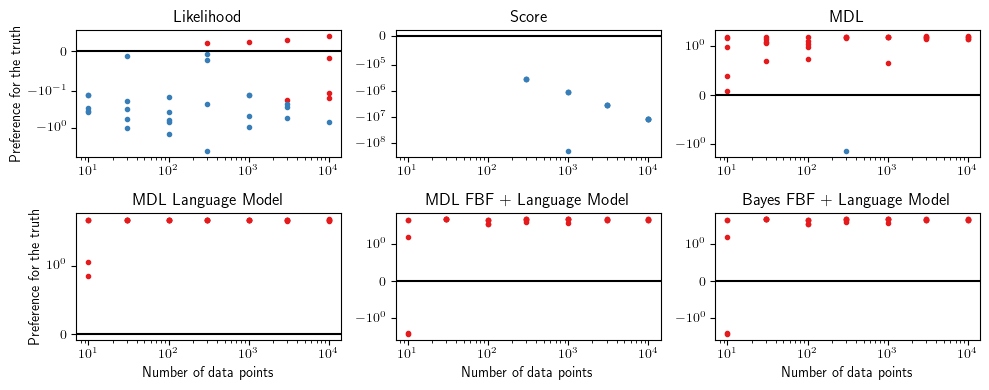

In [256]:
name = 'korns_4'; true_eq = 'a0 + a1*sin(x)'
all_N = np.array([10, 30, 100, 300, 1000, 3000, 10000])
# all_N = np.array([10,])
frac_sigx = 0.5
nsamp = 5
# nsamp = 1
method_labels = ['Likelihood', 'Score', 'MDL', 'MDL Language Model', 'MDL FBF + Language Model', 'Bayes FBF + Language Model']
all_linthresh = [0.1, 1e5, 1, 1, 1, 1]

delta_loss = np.empty((6, len(all_N), nsamp))
has_truth = np.empty(delta_loss.shape, dtype=bool)

for i, nx in enumerate(all_N):
    for samp in range(nsamp):
        fname = f'{name}_{nx}_{frac_sigx}_{samp}'
        print(fname)
        d = pd.read_csv(f'../scripts/output/output_{fname}/selection_summary.csv', delimiter=';')
        for j in range(delta_loss.shape[0]):
            f0 = d['f0'][j]
            f1 = d['f1'][j]
            ftrue = d['ftrue'][j]
            has_truth[j,i,samp] = ((f0 == ftrue) or (f1 == ftrue))
#                 print(f0, '///', f1, '///', true_eq, '///', (f0 == true_eq) or (f1 == true_eq))
            if f0 == ftrue:
                delta_loss[j,i,samp] = d['loss1'][j] - d['loss0'][j]
            elif f1 == ftrue:
                delta_loss[j,i,samp] = d['loss0'][j] - d['loss1'][j]
            else:
                delta_loss[j,i,samp] = d['loss0'][j] - d['losstrue'][j]

fig, axs = plt.subplots(2, int(np.ceil(delta_loss.shape[0]/2)), figsize=(10,4), sharex=True)
for i in range(axs.shape[0]):
    axs[i,0].set_ylabel('Preference for the truth')
for i in range(axs.shape[1]):
    axs[-1,i].set_xlabel('Number of data points')
axs = axs.flatten()
cm = plt.get_cmap('Set1')
for i in range(delta_loss.shape[0]):
    for j in range(delta_loss.shape[2]):
        axs[i].semilogx(all_N[has_truth[i,:,j]], delta_loss[i,has_truth[i,:,j],j], '.', color=cm(0))
        axs[i].semilogx(all_N[~has_truth[i,:,j]], delta_loss[i,~has_truth[i,:,j],j], '.', color=cm(1))
    axs[i].set_yscale('symlog', linthresh=all_linthresh[i])
    axs[i].axhline(y=0, color='k')
    axs[i].set_title(method_labels[i])
    axs[i].tick_params(labelbottom=True)
    

fig.tight_layout()

ntop2 = np.sum(has_truth, axis=(1,2))
for i in range(len(ntop2)):
    print('Method %s: %i of %i have truth in top 2'%(method_labels[i],ntop2[i],nsamp*len(all_N)))
        


nguyen_8
Method Likelihood: 0 of 35 have truth in top 2
Method Score: 34 of 35 have truth in top 2
Method MDL: 35 of 35 have truth in top 2
Method MDL 
Language 
Model: 0 of 35 have truth in top 2
Method MDL FBF + 
Language 
Model: 7 of 35 have truth in top 2
Method Bayes FBF + 
Language 
Model: 7 of 35 have truth in top 2

korns_1
Method Likelihood: 1 of 35 have truth in top 2
Method Score: 34 of 35 have truth in top 2
Method MDL: 16 of 35 have truth in top 2
Method MDL 
Language 
Model: 6 of 35 have truth in top 2
Method MDL FBF + 
Language 
Model: 0 of 35 have truth in top 2
Method Bayes FBF + 
Language 
Model: 0 of 35 have truth in top 2

korns_4
Method Likelihood: 8 of 35 have truth in top 2
Method Score: 0 of 35 have truth in top 2
Method MDL: 34 of 35 have truth in top 2
Method MDL 
Language 
Model: 35 of 35 have truth in top 2
Method MDL FBF + 
Language 
Model: 35 of 35 have truth in top 2
Method Bayes FBF + 
Language 
Model: 35 of 35 have truth in top 2

korns_6
Method Likeli

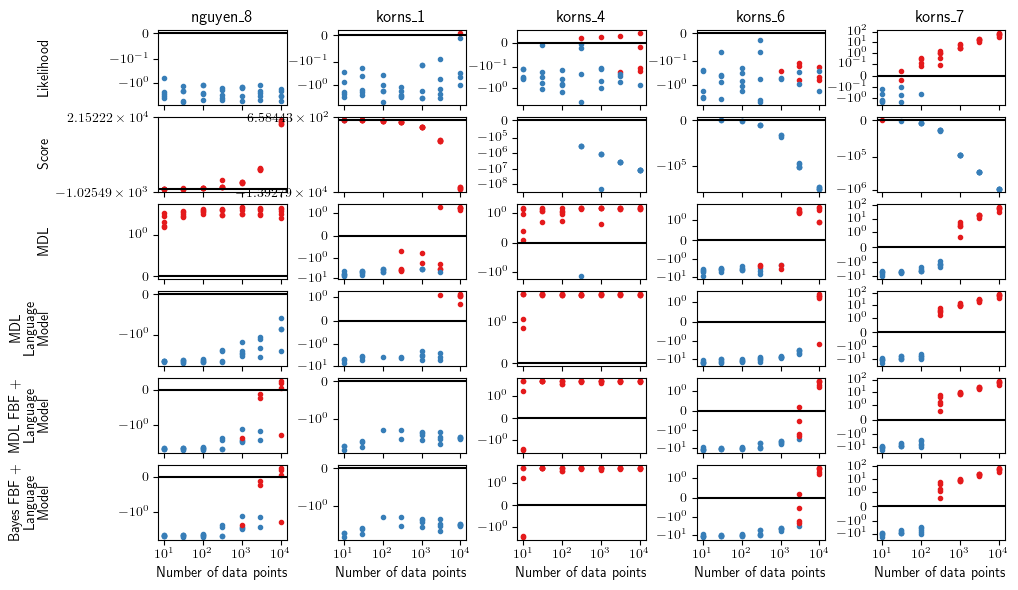

In [291]:
all_name = ['nguyen_8', 'korns_1', 'korns_4', 'korns_6', 'korns_7']
all_N = np.array([10, 30, 100, 300, 1000, 3000, 10000])
xticks = [10, 100, 1000, 10000]
frac_sigx = 0.5
nsamp = 5
method_labels = ['Likelihood', 'Score', 'MDL', 'MDL \nLanguage \nModel', 
                 'MDL FBF + \nLanguage \nModel', 'Bayes FBF + \nLanguage \nModel']
all_linthresh = [0.1, 1e5, 1, 1, 1, 1]

fig, axs = plt.subplots(len(method_labels), len(all_name), figsize=(10,6), sharex=True)
cm = plt.get_cmap('Set1')

for bnum, name in enumerate(all_name):
    
    print(f'\n{name}')

    axs[0, bnum].set_title(name)
    
    delta_loss = np.empty((len(method_labels), len(all_N), nsamp))
    has_truth = np.empty(delta_loss.shape, dtype=bool)

    for i, nx in enumerate(all_N):
        for samp in range(nsamp):
            fname = f'{name}_{nx}_{frac_sigx}_{samp}'
            d = pd.read_csv(f'../scripts/output/output_{fname}/selection_summary.csv', delimiter=';')
            for j in range(delta_loss.shape[0]):
                f0 = d['f0'][j]
                f1 = d['f1'][j]
                ftrue = d['ftrue'][j]
                has_truth[j,i,samp] = ((f0 == ftrue) or (f1 == ftrue))
                if f0 == ftrue:
                    delta_loss[j,i,samp] = d['loss1'][j] - d['loss0'][j]
                elif f1 == ftrue:
                    delta_loss[j,i,samp] = d['loss0'][j] - d['loss1'][j]
                else:
                    delta_loss[j,i,samp] = d['loss0'][j] - d['losstrue'][j]
    
    for i in range(delta_loss.shape[0]):
        for j in range(delta_loss.shape[2]):
            axs[i,bnum].semilogx(all_N[has_truth[i,:,j]], delta_loss[i,has_truth[i,:,j],j], '.', color=cm(0))
            axs[i,bnum].semilogx(all_N[~has_truth[i,:,j]], delta_loss[i,~has_truth[i,:,j],j], '.', color=cm(1))
        axs[i,bnum].set_yscale('symlog', linthresh=all_linthresh[i])
        axs[i,bnum].axhline(y=0, color='k')
        axs[i,bnum].set_xticks(xticks)
        
    ntop2 = np.sum(has_truth, axis=(1,2))
    for i in range(len(ntop2)):
        print('Method %s: %i of %i have truth in top 2'%(method_labels[i].strip('\n'),ntop2[i],nsamp*len(all_N)))
    

for i in range(axs.shape[0]):
    axs[i,0].set_ylabel(method_labels[i], fontsize=10)
for i in range(axs.shape[1]):
    axs[-1,i].set_xlabel('Number of data points')
fig.tight_layout()
fig.subplots_adjust(hspace=0.15, wspace=0.4)
fig.align_ylabels(axs[:,0])
        
fig.savefig('../figs/benchmark_results.pdf', bbox_inches='tight', transparent=True)